In [1]:
import os.path as osp
import os, sys
sys.path.insert(0, osp.abspath(osp.join(os.getcwd(), "..")))

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import vlkit.plt as vlplt

from vlkit.medical import read_dicom_data

import torch
import numpy as np
from mmcv.utils import Config, DictAction
from scipy.ndimage import gaussian_filter1d
from scipy.io import loadmat

from ct_sampler import CTSampler
from utils import load_dce
from pharmacokinetic import (
    np2torch,
    calculate_reconstruction_loss,
    compare_results,
    evaluate_curve
)
from aif import get_aif, interp_aif

from torchvision.transforms._functional_tensor import _get_gaussian_kernel1d

/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
device = torch.device('cuda:0')
dce_data = load_dce.load_dce_data('../../dicom/10042_1_1Wnr0444/20161209/iCAD-MCC_33000', device=device)
max_base = dce_data['max_base'].item()
acquisition_time = dce_data['acquisition_time']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:02<00:00, 655.66it/s]


In [3]:
cfg = Config.fromfile('../configs/aif_interp.py')
param_sampler = CTSampler(cfg.sampler)

if cfg.aif != 'mixed':
    aif_cp, aif_t = get_aif(cfg.aif, acquisition_time, max_base, device=device)
else:
    aif_cp, aif_t = get_aif('parker', acquisition_time, max_base, device=device)
    weinmann_aif, _ = get_aif('weinmann', acquisition_time, max_base, device=device)
    fh_aif, _ = get_aif('fh', acquisition_time, max_base, device=device)

In [4]:
batch_size = 20
params = param_sampler.sample(batch_size)

In [5]:
ktrans, kep, t0 = params["ktrans"], params["kep"], params["t0"]

In [6]:
ct = evaluate_curve(ktrans, kep, t0, aif_t, aif_cp, t=acquisition_time)
noise_scale = np.random.uniform(low=0, high=1, size=(batch_size))
noise_scale = torch.from_numpy(noise_scale).to(ct)
noise = torch.randn(ct.shape, device=ct.device) * noise_scale.view(-1, 1)
ct = ct + ct * noise
ct[ct < 0] = 0

ct = ct.unsqueeze(dim=1)
print(ct.shape)

torch.Size([20, 1, 75])


In [7]:
def pyramid1d(x, sigmas=(1, 2, 3)):
    assert isinstance(x, torch.Tensor)
    assert x.ndim == 3 and x.shape[1] == 1
    n, _, d = x.shape
    smoothed = [x]
    for s in sigmas:
        smoothed.append(gaussian_filter1d(x, s))
    return torch.cat(smoothed, dim=1)

def gaussian_filter1d(x, sigma, truncate=4):
    # x: [n c h]
    assert x.ndim == 3
    kernel_size = int(sigma * truncate + 1)
    kernel = _get_gaussian_kernel1d(kernel_size=kernel_size, sigma=sigma)
    kernel = kernel.view(1, 1, -1)
    padding = (kernel_size - 1) // 2
    x = torch.nn.functional.pad(x, pad=[padding, padding],  mode='reflect')
    y = torch.nn.functional.conv1d(x, kernel)
    return y

## synthetical data

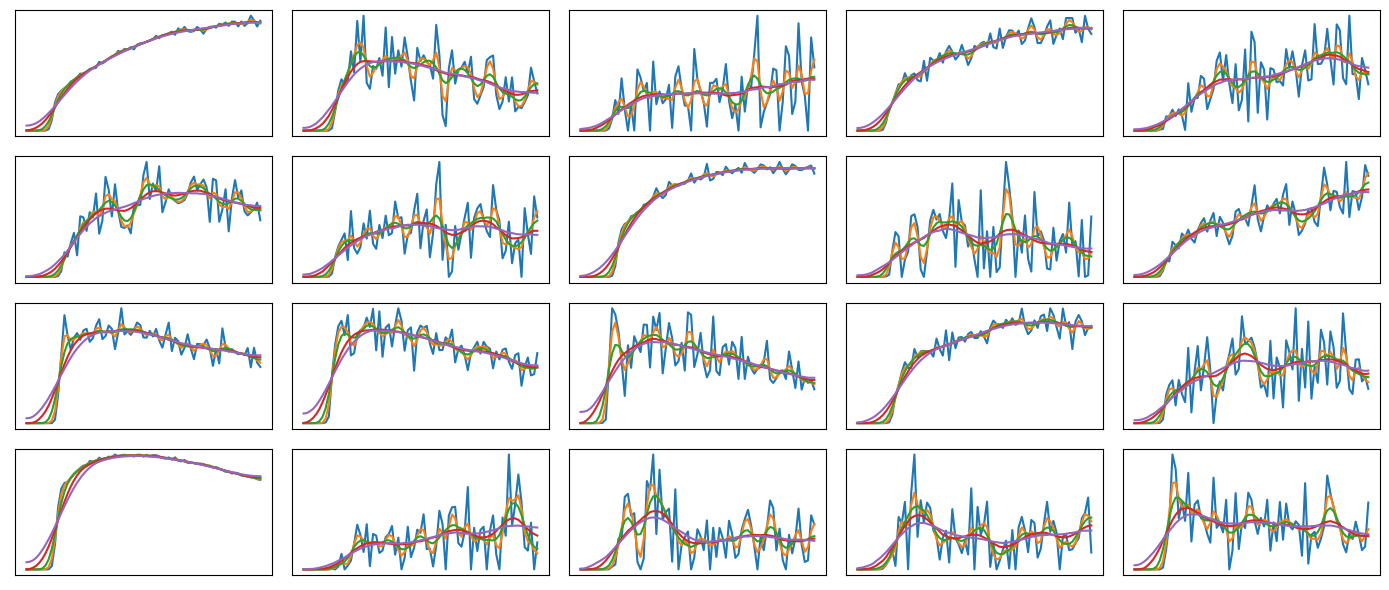

In [8]:
fig, axes = plt.subplots(4, 5, figsize=(14, 6))
vlplt.clear_ticks(axes)

pyramid = pyramid1d(ct, sigmas=[1, 2, 4, 6])

for i, ax in enumerate(axes.flatten()):
    for j in range(pyramid.shape[1]):
        ax.plot(pyramid[i, j])
plt.tight_layout()

## Real data

In [9]:
data = loadmat('../../tmp/10042_1_003Tnq2B-20180212.mat')
# ct = read_dicom_data('../../dicom/10042_1_003Tnq2B/20180212/t1_twist_tra_dyn_29/')
# ct = np.concatenate([c[:, :, None] for c in ct], axis=-1)
# ct = ct.reshape(160, 160, 75, 20)

In [10]:
ct = torch.from_numpy(data['dce_ct'][np.logical_and(data['ktrans'] >= 0.5, data['ktrans'] <= 1)])
ct = ct.unsqueeze(dim=1).float()

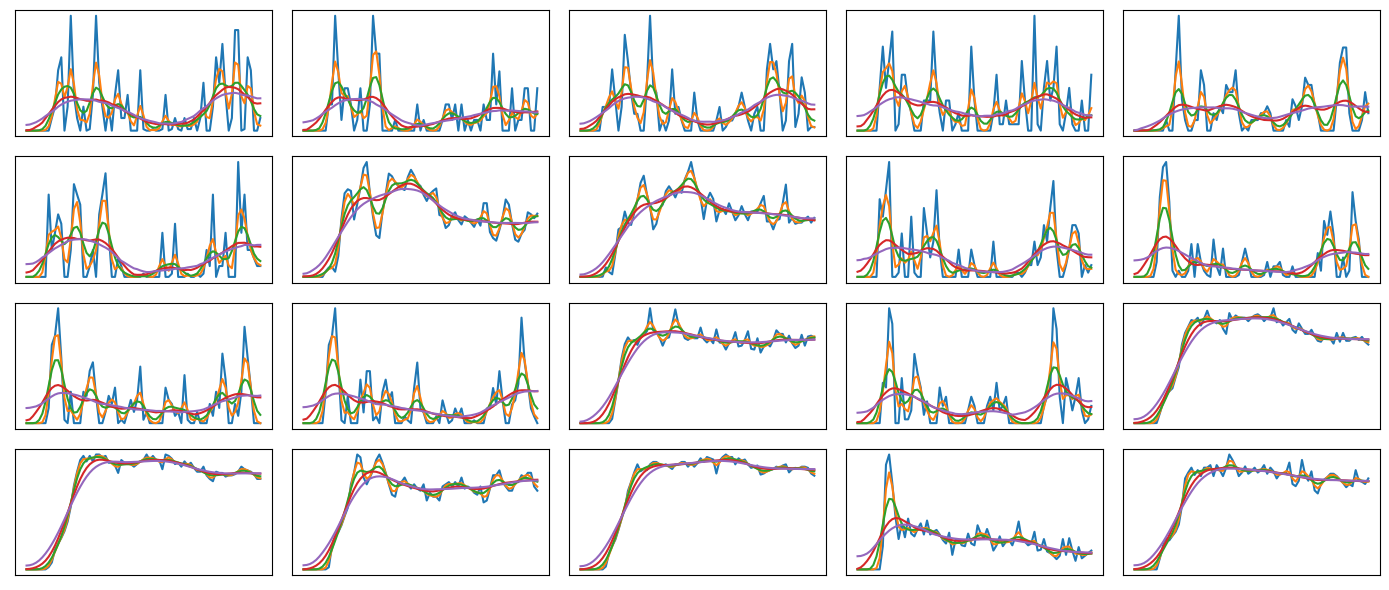

In [11]:
fig, axes = plt.subplots(4, 5, figsize=(14, 6))
vlplt.clear_ticks(axes)

pyramid = pyramid1d(ct, sigmas=[1, 2, 4, 6])

for i, ax in enumerate(axes.flatten()):
    for j in range(pyramid.shape[1]):
        ax.plot(pyramid[i, j])
plt.tight_layout()